# Results

### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from prettytable import PrettyTable
import os
import sys
from dotenv import load_dotenv
from joblib import Memory

### Import Custom Classes

In [2]:
# Add custom directories to the system path for importing classes
sys.path.extend(['../src/data', '../src/models', '../src/visualization'])

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Import custom classes
from src.models.evaluate_strategy import EvaluateStrategy
from src.models.momentum_strategy import MomentumStrategy
from src.visualization.visualize_results import Visualizer
from src.data.load_data import Dataloader
from src.data.process_data import Dataprocessor

# Create instances of the imported classes
strategy_evaluator = EvaluateStrategy()
momentum = MomentumStrategy()
visualizer = Visualizer()
dataloader = Dataloader()
dataprocessor = Dataprocessor()

### Set Environment Variable

Please set the environment variable as a .env file as described in the README.
Should you wish to change the folder Name from "SPX-Industry-Momentum" (which it is called by default after cloning from Github), please change the variable ProjectName.

In [3]:
# Load environment variables from a .env file
load_dotenv(dotenv_path='environment_variables.env')

# Set and retrieve the project path
ProjectName = 'SPX-Industry-Momentum'
os.environ['RESEARCH_PATH'] = os.environ.get('PROJECT_ROOT')
research_path = os.environ.get('RESEARCH_PATH')

# Check if the path is set and print it
if research_path:
    path = os.path.join(research_path, ProjectName)
    file_path = os.path.join(path, 'data', 'raw')
    picture_path = os.path.join(path, 'reports', 'figures')
else:
    print("RESEARCH_PATH environment variable is not set.")

Project Path: /Users/fabianmugrauer/Desktop/Uni/Studium/Master/HS23/Digital Tools/Project/SPX-Industry-Momentum
Data Path: /Users/fabianmugrauer/Desktop/Uni/Studium/Master/HS23/Digital Tools/Project/SPX-Industry-Momentum/data/raw


### Set the caching directory

Some functions in the following are cached for faster runtime.

In [ ]:
# Setup joblib Memory for caching
cachedir = './cache_directory'  # Set your cache directory
memory = Memory(cachedir, verbose=0)

### Import and Process Data

Data (namely Total Returns of the SPX, SPX Sectors, SPX Industry Groups as well as the the risk free return (yield of 3 month generic US T-bills)) will be loaded from a csv file. Should you wish to use your own data or use more up-to-date data please place a csv file  in data/raw structured identicaly to the current file.

In a second step, the data is being processed so that the momentum backtest can start. We will calculate daily and monhtly returns, adjust the interest rate to calculate monthly excess returns and process the dates to get datetime variables as well as to know when months start in our datelist to do rebalancings accordingly.

In [4]:

# Decorate the load_data function with joblib cache
load_data_csv_cached = memory.cache(dataloader.load_data_csv)

# Define csv file to load
file_name = 'Bloomberg_Download.csv'

# Load the data using the cached function
dates_dateformat, SPXT, Sectors, Rf, Industry_Groups = load_data_csv_cached(file_path, file_name)

# Decorate the process_data functions with joblib cache
process_data_cached = memory.cache(dataprocessor.process_data)

# Process the data using the cached functions
dates_datetime, numericDate_d, firstDayList, lastDayList, dates4plot, Sectors_returns_d, Sectors_returns_m, sector_names, Industry_Groups_returns_d, Industry_Groups_returns_m, IG_names, SPXT_returns_d, SPXT_returns_m, SPXT_Xsreturns_m, rf_d_unadjusted, rf_d, rf_d_monthly = process_data_cached(dates_dateformat, Sectors, Industry_Groups, SPXT, Rf)

### Define Meta-variables for Analysis

We set transaction costs at 0.1% , number of long positions taken at 3, the lookback period at 9 months and the holding period at 3 months. All of these parameters will be robustness checked. 

Feel free to change these variables should you wish to backtest with diverging parameters.

In [5]:
# Define analysis parameters
trx_cost = 0.001
nLong = 3
startMonth = 13
lookback_period_start, lookback_period_end = 9, 1
holding_period = 3

### Run Sector Momentum Analysis

In [6]:
# Perform the momentum strategy backtest
xsReturns_TC, totalReturns_TC, weights = momentum.backtest_momentum(Sectors_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end, holding_period, startMonth, nLong, 0, trx_cost)
xsReturns_TC_IG, totalReturns_TC_IG, weights_IG = momentum.backtest_momentum(Industry_Groups_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end, holding_period, startMonth, nLong, 0, trx_cost)

# Long / Short implementation
xsReturns_TC_LS, totalReturns_TC_LS, weights_LS = momentum.backtest_momentum(Sectors_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end, holding_period, startMonth, nLong, 3, trx_cost)
xsReturns_TC_IG_LS, totalReturns_TC_IG_LS, weights_IG_LS = momentum.backtest_momentum(Industry_Groups_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end, holding_period, startMonth, nLong, 3, trx_cost)

### Visual Analysis of Long and Long/Short Sector and Industry Group Momentum

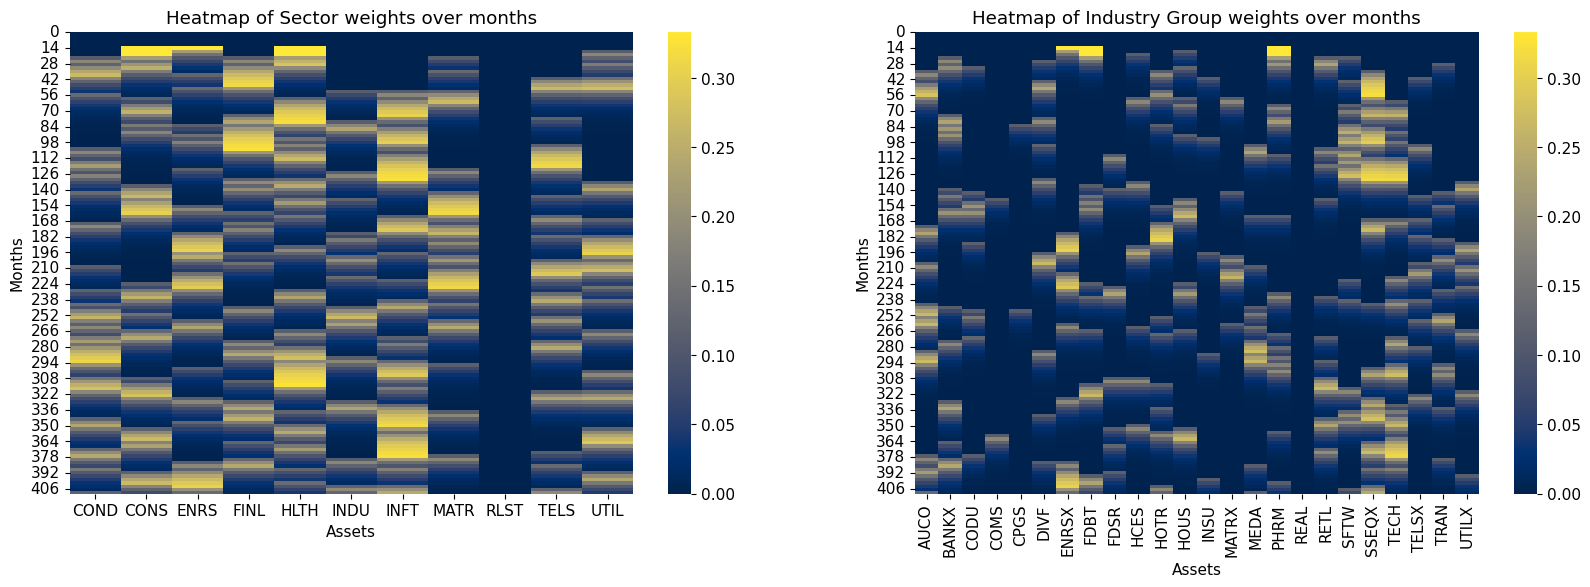

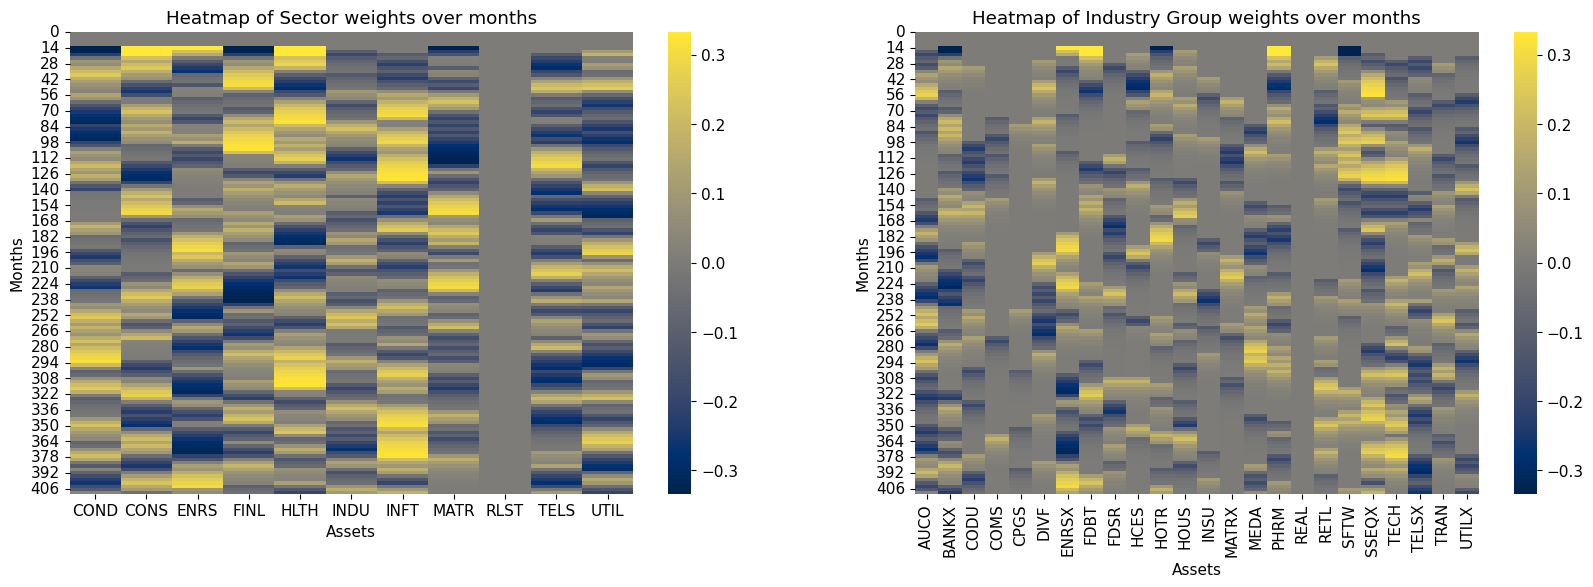

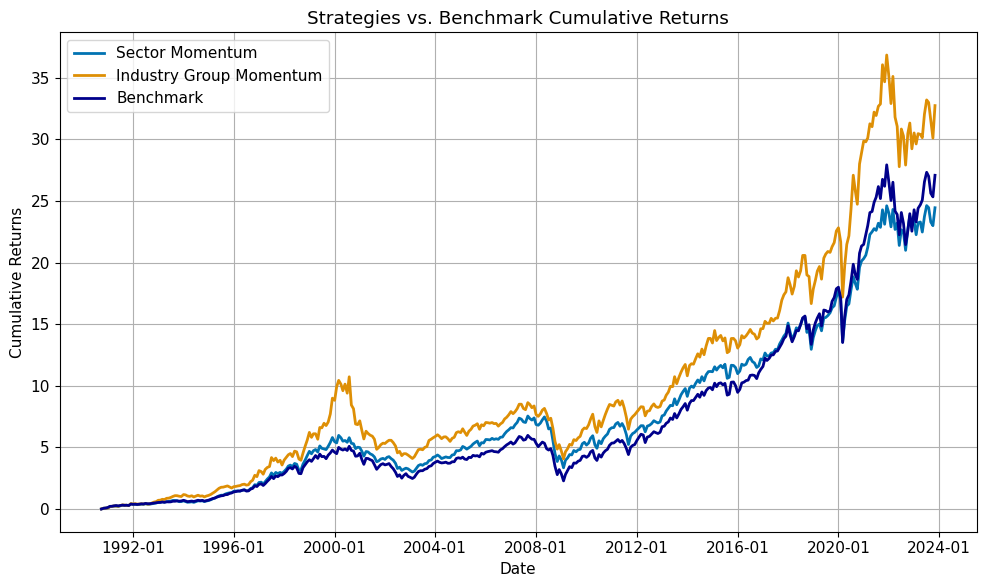

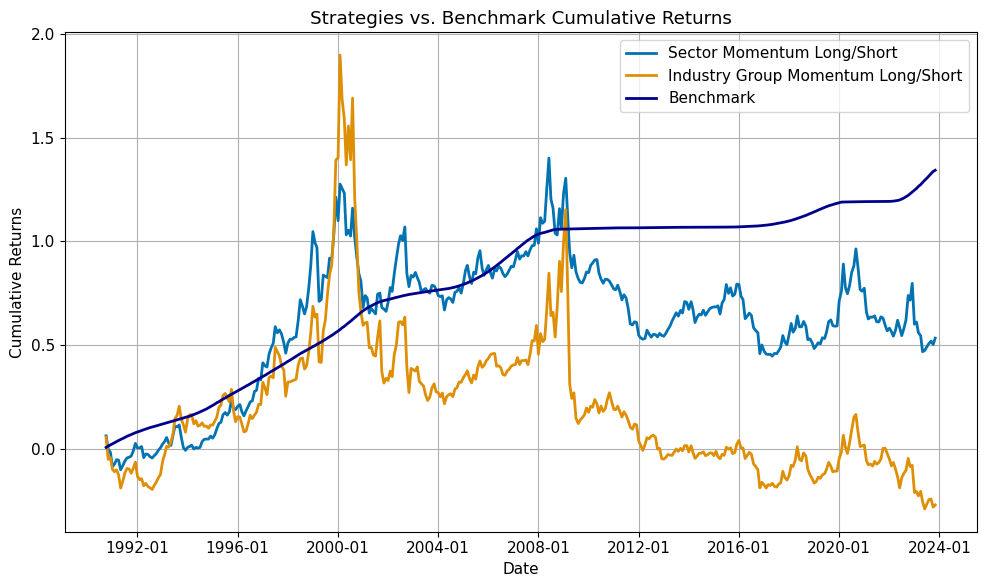

In [7]:
# Visualize the weights using a heatmap

fig1 = visualizer.create_colorheatmap(weights, weights_IG, sector_names, IG_names)
fig1.savefig(os.path.join(picture_path, 'strategy_weights_long.png'), dpi=300)

# Long/Short
fig2 = visualizer.create_colorheatmap(weights_LS, weights_IG_LS, sector_names, IG_names)
fig2.savefig(os.path.join(picture_path, 'strategy_weights_long_short.png'), dpi=300)

# Visualize strategy returns against the benchmark
fig3 = visualizer.plot_strategies_with_benchmark(dates4plot, totalReturns_TC, SPXT_returns_m, 'Sector Momentum', startMonth, totalReturns_TC_IG, 'Industry Group Momentum')
fig3.savefig(os.path.join(picture_path, 'strategy_plot.png'), dpi=300)

fig4 = visualizer.plot_strategies_with_benchmark(dates4plot, totalReturns_TC_LS, rf_d_monthly, 'Sector Momentum Long/Short', startMonth, totalReturns_TC_IG_LS, 'Industry Group Momentum Long/Short')
fig4.savefig(os.path.join(picture_path, 'strategy_plot_long_short.png'), dpi=300)

### Summary Performance Statistics of Long and Long/Short Sector and Industry Group Momentum

In [8]:
# Calculate performance metrics
ArithmAvgTotalReturn, ArithmAvgXsReturn, StdXsReturns, SharpeArithmetic, MinXsReturn, MaxXsReturn, SkewXsReturn, KurtXsReturn, alphaArithmetic, tvaluealpha, betas, summary_table = strategy_evaluator.summarize_performance(xsReturns_TC, rf_d_monthly, SPXT_Xsreturns_m, 12, startMonth, 'Sectors')
ArithmAvgTotalReturn_IG, ArithmAvgXsReturn_IG, StdXsReturns_IG, SharpeArithmetic_IG, MinXsReturn_IG, MaxXsReturn_IG, SkewXsReturn_IG, KurtXsReturn_IG, alphaArithmetic_IG, tvaluealpha_IG, betas_IG, summary_table_IG = strategy_evaluator.summarize_performance(xsReturns_TC_IG, rf_d_monthly, SPXT_Xsreturns_m, 12, startMonth, 'Industry Groups')
ArithmAvgTotalReturn_S, ArithmAvgXsReturn_S, StdXsReturns_S, SharpeArithmetic_S, MinXsReturn_S, MaxXsReturn_S, SkewXsReturn_S, KurtXsReturn_S, alphaArithmetic_S, tvaluealpha_S, betas_S, summary_table_S = strategy_evaluator.summarize_performance(xsReturns_TC_LS, rf_d_monthly, rf_d_monthly, 12, startMonth, 'Sectors')
ArithmAvgTotalReturn_IG_S, ArithmAvgXsReturn_IG_S, StdXsReturns_IG_S, SharpeArithmetic_IG_S, MinXsReturn_IG_S, MaxXsReturn_IG_S, SkewXsReturn_IG_S, KurtXsReturn_IG_S, alphaArithmetic_IG_S, tvaluealpha_IG_S, betas_IG_S, summary_table_IG_S = strategy_evaluator.summarize_performance(xsReturns_TC_IG_LS, rf_d_monthly, rf_d_monthly, 12, startMonth, 'Industry Groups')

# Merge the tables
combined_table = summary_table.rename(columns={'Value': 'Sectors Long'}).merge(summary_table_IG.rename(columns={'Value': 'Industry Groups Long'}), on='Statistic')
combined_table = combined_table.merge(summary_table_S.rename(columns={'Value': 'Sectors Long/Short'}), on='Statistic')
combined_table = combined_table.merge(summary_table_IG_S.rename(columns={'Value': 'Industry Groups Long/Short'}), on='Statistic')

# Convert the DataFrame to a PrettyTable
pretty_table = PrettyTable()
pretty_table.field_names = combined_table.columns.tolist()
for row in combined_table.itertuples(index=False):
    formatted_row = [f'{value:.2f}' if isinstance(value, float) else value for value in row]
    pretty_table.add_row(formatted_row)

# Align 'Statistic' column to the left
pretty_table.align['Statistic'] = 'l'

print(pretty_table)

+---------------+--------------+----------------------+--------------------+----------------------------+
| Statistic     | Sectors Long | Industry Groups Long | Sectors Long/Short | Industry Groups Long/Short |
+---------------+--------------+----------------------+--------------------+----------------------------+
| Total Return  |    10.95     |        12.28         |        1.85        |            0.43            |
| Excess Return |     8.38     |         9.71         |       -0.72        |           -2.14            |
| STD           |    15.03     |        17.96         |       10.52        |           16.41            |
| Sharpe Ratio  |     0.56     |         0.54         |       -0.07        |           -0.13            |
| Min           |    -18.81    |        -20.09        |       -13.59       |           -26.19           |
| Max           |    14.14     |        16.01         |        8.58        |           20.13            |
| Skewness      |    -0.61     |        -0.34 

### Robustness Checks

#### Lookback Perdiod

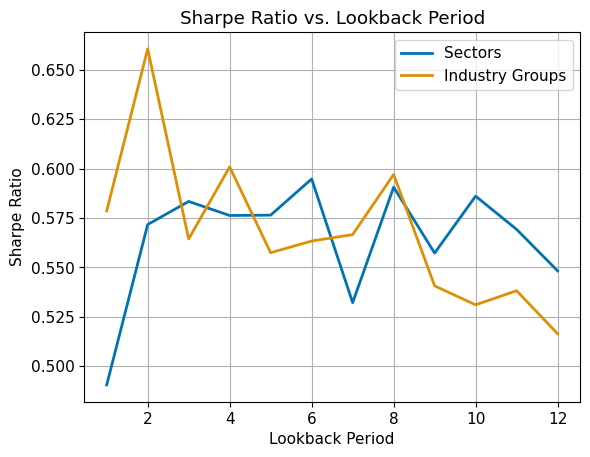

In [9]:
# Define parameters and initialize empty lists or arrays
lookback_period_range = range(1, 13)  # Example range from 3 to 12

# Perform the robustness check for lookback period
sharpe_ratios_lookback = EvaluateStrategy.perform_robustness_check(
    momentum, 'lookback', lookback_period_range, Sectors_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

sharpe_ratios_lookback_IG = EvaluateStrategy.perform_robustness_check(
    momentum, 'lookback', lookback_period_range, Industry_Groups_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

# Plot the results for lookback period robustness check
fig5 = visualizer.plot_robustness_check(lookback_period_range, sharpe_ratios_lookback, 'Lookback Period', sharpe_ratios_lookback_IG, ['Sectors', 'Industry Groups']) 
fig5.savefig(os.path.join(picture_path, 'robustness_check_lb.png'), dpi=300)

#### Holding Period

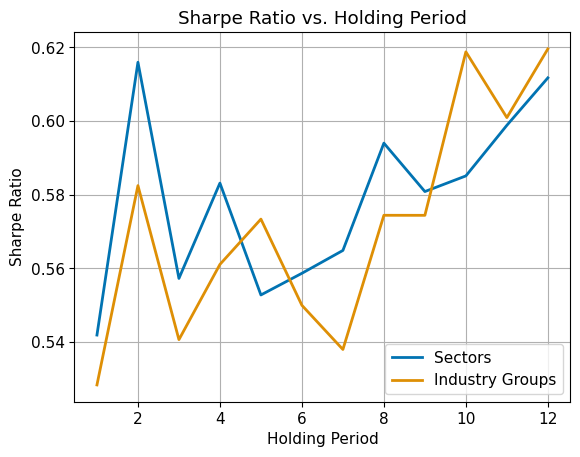

In [10]:
# Define the range for the investment horizon
investment_horizon_range = range(1, 13)  # Example range

# Perform the robustness check for investment horizon
sharpe_ratios_investment_horizon = EvaluateStrategy.perform_robustness_check(
    momentum, 'investment_horizon', investment_horizon_range, Sectors_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

sharpe_ratios_investment_horizon_IG = EvaluateStrategy.perform_robustness_check(
    momentum, 'investment_horizon', investment_horizon_range, Industry_Groups_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

# Plot the results for investment horizon robustness check
fig6 = visualizer.plot_robustness_check(investment_horizon_range, sharpe_ratios_investment_horizon, 'Holding Period', sharpe_ratios_investment_horizon_IG, ['Sectors', 'Industry Groups'])
fig6.savefig(os.path.join(picture_path, 'robustness_check_ih.png'), dpi=300)

#### Number of Holdings

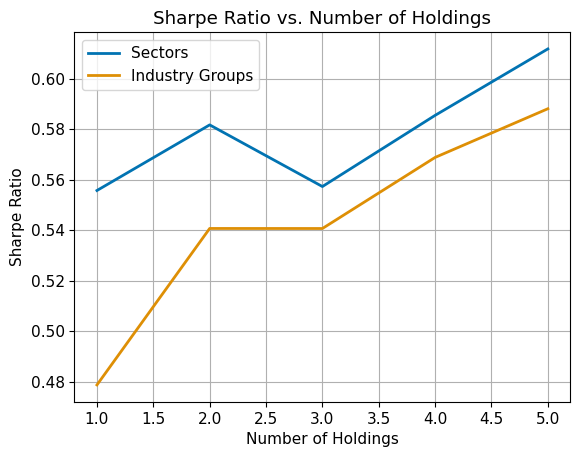

In [11]:
# Define the range for the number of holdings
holdings_range = range(1, 6)  # Example range

# Perform the robustness check for number of holdings
sharpe_ratios_holdings = EvaluateStrategy.perform_robustness_check(
    momentum, 'holdings', holdings_range, Sectors_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

sharpe_ratios_holdings_IG = EvaluateStrategy.perform_robustness_check(
    momentum, 'holdings', holdings_range, Industry_Groups_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

# Plot the results for number of holdings robustness check
fig7 = visualizer.plot_robustness_check(holdings_range, sharpe_ratios_holdings, 'Number of Holdings', sharpe_ratios_holdings_IG,['Sectors', 'Industry Groups'])
fig7.savefig(os.path.join(picture_path, 'robustness_check_holdings.png'), dpi=300)

#### Transaction Costs

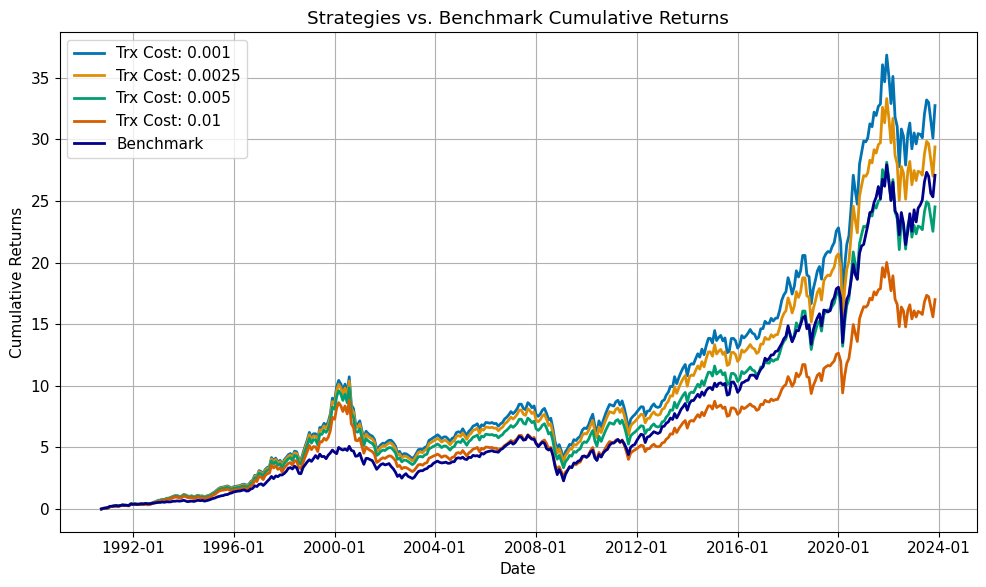

In [12]:
tx_costs = [0.001, 0.0025, 0.005, 0.01]
total_returns_tx_costs = []
total_returns_tx_costs_IG  = []
labels = []

for trx_cost in tx_costs:
    _, totalReturns_TC, _ = momentum.backtest_momentum(
        Sectors_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end,
        holding_period, startMonth, nLong, 0, trx_cost
    )

    _, totalReturns_TC_IG, _ = momentum.backtest_momentum(
        Industry_Groups_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end,
        holding_period, startMonth, nLong, 0, trx_cost
    )

    # Storing the total returns in a list
    total_returns_tx_costs.append(totalReturns_TC)
    total_returns_tx_costs_IG.append(totalReturns_TC_IG)

    # Creating corresponding labels
    labels.append(f'Trx Cost: {trx_cost}')

fig8 = visualizer.plot_strategies_with_benchmark(dates4plot, total_returns_tx_costs_IG, SPXT_returns_m, labels, startMonth)
fig8.savefig(os.path.join(picture_path, 'robustness_check_tc.png'), dpi=300)